## Prerequisites
 **LOCAL** Cytoscape (3.10.0 or greater) + **Local** Jupyter environment (including py4cytoscape).

### Setup required 

- Install Cytoscape on your PC. (See https://cytoscape.org/download.html)
- Install Jupyter on your PC. (See https://jupyter.org/install)
- Install py4cytoscape with `pip install py4cytoscape` on your PC.

## Getting started
**NOTE: To run this notebook, you must manually start Cytoscape first – don’t proceed until you have started Cytoscape.**

First, confirm that you have everything installed and running:

In [6]:
### necessary imports
import py4cytoscape as p4c
import os
import pandas as pd
from itertools import chain
import time
from datetime import date
import numpy as np
### for showing examples and distribution figures
from IPython.display import Image, display
import matplotlib.pyplot as plt

### checking that cytoscape is running
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.6.0'}

# GOLDfinder results visualization
Start by specifying the input directory, that includes all files generated by GOLDfinder, and the output directory, where new files will be generated

In [2]:
### set input and output directories
inputdir = '/media/hdd_2tb/side_projects/amycolatopsis_pangenome/emil_GOLDfinder_project/precomputed_results/s.pneumoniae.updated_coin_out1_6_newest/s.pneumoniae.updated_coin_out1_6_newest_windows/s.pneumoniae.updated_coin_out1_6_newest'
#outdir = '/media/hdd_2tb/side_projects/amycolatopsis_pangenome/emil_GOLDfinder_project/precomputed_results/s.pneumoniae.updated_coin_out1_6_newest/s.pneumoniae.updated_coin_out1_6_newest_windows/s.pneumoniae.updated_coin_out1_6_newest'
outdir = '/media/hdd_2tb/side_projects/amycolatopsis_pangenome/emil_GOLDfinder_project/clean_publication_figures'
examples_dir = inputdir

### make output folder if it doesn't exist already
if not os.path.exists(outdir):
    os.mkdir(outdir)
    print("Created folder: %s" %(outdir))

In [3]:
### import styles file - this should also be present in your GOLDfinder results folder (input)
styles_file = os.path.join(inputdir,'GOLDfinder_custom_styles.xml')
print("Importing visual styles")
p4c.import_visual_styles(styles_file)
### checking layout names and tweakable attributes
#p4c.get_layout_names()
#p4c.get_layout_property_names('attribute-circle')
#p4c.get_layout_property_names('force-directed')
#p4c.get_layout_name_mapping()

Importing visual styles


['GOLDfinder-COINfinder_copycatFig1',
 'GOLDfinder_allassoc_genebasedDis',
 'GOLDfinder_allassoc',
 'GOLDfinder_allassoc_partialDis']

### 0: Importing information & preparing data for network visualization
The following code block imports all information necessary from the GOLDfinder results files and prepares the data in a format ready to be visualized. No network is generated in cytoscape yet.

In [5]:
def check_existence(filepath):
    if not os.path.exists(filepath):
        return False
    else:
        return True
    
### using GOLDfinder generated output files - 11.01.24 - change file paths as needed
cytoscape_input_file = os.path.join(inputdir, 'cytoscape_input.csv')
if not check_existence(cytoscape_input_file):
    print(f"File not found. Check input directory:\n{cytoscape_input_file}")
association_clusters_file = os.path.join(inputdir, 'association_clusters.txt')
if not check_existence(association_clusters_file):
    print(f"File not found. Check input directory:\n{association_clusters_file}")
associated_pairs_file = os.path.join(inputdir, 'simultaneous_association_significant_pairs.txt')
if not check_existence(associated_pairs_file):
    print(f"File not found. Check input directory:\n{associated_pairs_file}")
dissociated_pairs_file = os.path.join(inputdir, 'simultaneous_dissociation_significant_pairs.txt')
if not check_existence(dissociated_pairs_file):
    print(f"File not found. Check input directory:\n{dissociated_pairs_file}")


### get info from cytoscape_input file
edges_df = pd.read_csv(cytoscape_input_file)
gene_assoc_edges_df = edges_df[edges_df['pair_type'] == 'gene-gene-assoc']
cluster_edges_df = edges_df[edges_df['pair_type'] == 'cluster-cluster-dissoc']
cluster_assoc_edges_df = edges_df[edges_df['pair_type'] == 'cluster-cluster-assoc']
cl_cl_assoc_pairs = list(zip(cluster_assoc_edges_df['Node1'],cluster_assoc_edges_df['Node2']))
cl_cl_assoc_pairs = [list(ele) for ele in cl_cl_assoc_pairs]
cl_cl_disassociation_pairs = list(zip(cluster_edges_df['Node1'],cluster_edges_df['Node2']))
cl_cl_disassociation_pairs = [list(ele) for ele in cl_cl_disassociation_pairs]
gene_to_cluster_edges_df = edges_df[edges_df['pair_type'] == 'gene-cluster-member']

print("Checking for empty cells in edge table...")
print("Found:", gene_to_cluster_edges_df.isnull().sum().sum())
gene_to_cluster_edges_df.fillna('', inplace=True)
coldict_edges = {'Node1':'source', 'Node2':'target'}
gene_assoc_edges_df.rename(columns=coldict_edges, inplace=True)
genes_list = gene_assoc_edges_df[['source','target']].values.tolist()
genes_list = list(set([item for row in genes_list for item in row]))

### get info from associated_pairs_file
assoc_pairs_df = pd.read_csv(associated_pairs_file)
gene1_df = assoc_pairs_df[['Gene_1', 'Gene_name_1', 'Annotation_1']]
gene2_df = assoc_pairs_df[['Gene_2', 'Gene_name_2', 'Annotation_2']]
coldict = {'Gene_1':'Gene', 'Gene_name_1':'Gene_name', 'Annotation_1':'Annotation',
           'Gene_2':'Gene', 'Gene_name_2':'Gene_name', 'Annotation_2':'Annotation'}
gene1_df.rename(columns=coldict, inplace=True)
gene2_df.rename(columns=coldict, inplace=True)
gene_nodes_df = pd.concat([gene1_df, gene2_df])
gene_nodes_df.drop_duplicates(inplace=True)
gene_nodes_df['id'] = gene_nodes_df['Gene']
gene_nodes_df['isgene'] = True

### get info from association_clusters_file
gene_to_cluster_dict = {}
cluster_list = []
with open(association_clusters_file, 'r') as infile:
    new_cluster = False
    for line in infile.readlines():
        line = line.rstrip()
        line = line.rstrip(',')
        if line.startswith('>'):
            cluster_num = line[1:].split(",")[0]
            cluster_list.append('cl_%s' %(cluster_num))
            continue
        if line in gene_to_cluster_dict.keys():
            if gene_to_cluster_dict[line] != 'cl_%s' %(cluster_num):
                print("ERROR: gene with multiple cluster assingments detected: %s" %(line))
                exit()
        gene_to_cluster_dict[line] = 'cl_%s' %(cluster_num)

### add cluster info to gene_nodes_df
gene_nodes_df['Cluster'] = gene_nodes_df['Gene'].map(gene_to_cluster_dict)
#print(gene_nodes_df) 
print("Checking for empty cells in node table...")
print("Found:", gene_nodes_df.isnull().sum().sum())
gene_nodes_df.fillna('', inplace=True)

### get asssociation info
gene_to_cluster_edges_df.rename(columns=coldict_edges, inplace=True)
cluster_node_df = pd.DataFrame(cluster_list, columns=['Gene'])
cluster_node_df['isgene'] = False
cluster_node_df['Cluster'] = cluster_node_df['Gene']
source_list = gene_to_cluster_edges_df['source'].tolist()
target_list = gene_to_cluster_edges_df['target'].tolist()
gene_to_cluster_edges_df['Cluster_num'] = gene_to_cluster_edges_df['target'].map(lambda x: int(x.replace('cl_','')))
nodes_list = list(set(genes_list + target_list))
gene_nodes_df['Cluster_num'] = gene_nodes_df['Cluster'].map(lambda x: int(x.replace('cl_','')) if x != '' else  0)


### calculate degree of each MCL cluster for disassociations
cluster_to_degree_dict = {}
#print(cluster_edges_df)
for clname in cluster_list:
    #print(clname)
    thisdegree = cluster_edges_df.Node1.str.count(clname).sum() + cluster_edges_df.Node2.str.count(clname).sum()
    cluster_to_degree_dict[clname] = thisdegree
    #print(clname, thisdegree)
cluster_edges_df['Node1_dis_degree'] = cluster_edges_df['Node1'].map(cluster_to_degree_dict)
cluster_edges_df['Node2_dis_degree'] = cluster_edges_df['Node2'].map(cluster_to_degree_dict)
cluster_edges_df['max_dis_degree'] = cluster_edges_df[['Node1_dis_degree', 'Node2_dis_degree']].max(axis=1)
cluster_node_df['dis_degree'] = cluster_node_df['Gene'].map(cluster_to_degree_dict)
gene_nodes_df = gene_nodes_df.assign(dis_degree=0)

all_assoc_clusterdis_nodes_df = pd.concat([gene_nodes_df, cluster_node_df])
all_assoc_clusterdis_nodes_df = all_assoc_clusterdis_nodes_df.set_index('Gene').reindex(index=nodes_list).fillna('').reset_index()
all_assoc_clusterdis_nodes_df['id'] = all_assoc_clusterdis_nodes_df['Gene']

### calculate degree of each MCL cluster for associations
cluster_to_assocdegree_dict = {}
for clname in cluster_list:
    thisdegree = cluster_assoc_edges_df.Node1.str.count(clname).sum() + cluster_assoc_edges_df.Node2.str.count(clname).sum()
    cluster_to_assocdegree_dict[clname] = thisdegree
cluster_assoc_edges_df['Node1_ass_degree'] = cluster_assoc_edges_df['Node1'].map(cluster_to_degree_dict)
cluster_assoc_edges_df['Node2_ass_degree'] = cluster_assoc_edges_df['Node2'].map(cluster_to_degree_dict)
cluster_assoc_edges_df['max_ass_degree'] = cluster_assoc_edges_df[['Node1_ass_degree', 'Node2_ass_degree']].max(axis=1)
cluster_node_df['ass_degree'] = cluster_node_df['Gene'].map(cluster_to_assocdegree_dict)
gene_nodes_df = gene_nodes_df.assign(ass_degree=0)

all_assoc_nodes_df = pd.concat([gene_nodes_df, cluster_node_df])
all_assoc_nodes_df = all_assoc_nodes_df.set_index('Gene').reindex(index=nodes_list).fillna('').reset_index()
all_assoc_nodes_df['id'] = all_assoc_nodes_df['Gene']

### get info for gene-gene associations happening across MCL clusters
def withinMCLconditions(row):
    if row['clustersource'] == row['clustertarget']:
        return True
    else:
        return False
gene_assoc_edges_df['clustersource'] = gene_assoc_edges_df['source'].map(gene_to_cluster_dict)
gene_assoc_edges_df['clustertarget'] = gene_assoc_edges_df['target'].map(gene_to_cluster_dict)
gene_assoc_edges_df['withinMCL'] = gene_assoc_edges_df.apply(withinMCLconditions, axis=1)
outside_MCL_gene_assoc_edges_df =gene_assoc_edges_df[gene_assoc_edges_df['withinMCL'] == False]
within_MCL_gene_assoc_edges_df = gene_assoc_edges_df[gene_assoc_edges_df['withinMCL'] == True]

sign_cl_cl_association_pairs_all = list(zip(outside_MCL_gene_assoc_edges_df['source'], outside_MCL_gene_assoc_edges_df['target']))
sign_cl_cl_association_pairs_all = list(chain.from_iterable([list(ele) for ele in sign_cl_cl_association_pairs_all]))


### get gene-gene disassociation info
genegenedissoc_df = pd.read_csv(dissociated_pairs_file)
dis_coldict_edges = {'Gene_1':'source', 'Gene_2':'target'}
genegenedissoc_df.rename(columns=dis_coldict_edges, inplace=True)
genegenedissoc_df['clustersource'] = genegenedissoc_df['source'].map(gene_to_cluster_dict)
genegenedissoc_df['clustertarget'] = genegenedissoc_df['target'].map(gene_to_cluster_dict)
genegenedissoc_df['withinMCL'] = genegenedissoc_df.apply(withinMCLconditions, axis=1)
outside_MCL_gene_disassoc_edges_df =genegenedissoc_df[genegenedissoc_df['withinMCL'] == False]
within_MCL_gene_disassoc_edges_df = genegenedissoc_df[genegenedissoc_df['withinMCL'] == True]           
if len(within_MCL_gene_disassoc_edges_df) > 0:
    print("\nWARNING: gene-gene disassociations happening within MCL clusters detected!!!!!!!")
    print(within_MCL_gene_disassoc_edges_df[['source','target','Annotation_1','Annotation_2','clustersource','clustertarget']])
    print(len(within_MCL_gene_assoc_edges_df))
    print("WARNING: gene-gene disassociations happening within MCL clusters detected!!!!!!!\n")
cluster_to_gene_dict = {}
for k,v in gene_to_cluster_dict.items():
    cluster_to_gene_dict[v] = cluster_to_gene_dict.get(v, []) + [k]


### show that all is done
print("\nDone")

Checking for empty cells in edge table...
Found: 0
Checking for empty cells in node table...
Found: 1554


/home/athina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/home/athina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/athina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-


          source      target                                     Annotation_1  \
91    group_1405        ktrB                             hypothetical protein   
93    group_1435        groL   23S rRNA (uracil-C(5))-methyltransferase RlmCD   
119   group_1713        argG                       Argininosuccinate synthase   
155    group_193  group_1546                             hypothetical protein   
209    group_224  group_3808                             hypothetical protein   
212    group_226  group_3808                             hypothetical protein   
257    group_254   group_439                             hypothetical protein   
258    group_254   group_224                             hypothetical protein   
299   group_2782   group_666                             hypothetical protein   
331   group_2974        ktrB            Ktr system potassium uptake protein B   
390   group_3465  group_3464     Glycosyltransferase-stabilizing protein Gtf2   
411   group_3701        yhd

/home/athina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 0: Visualizing MCL association clusters and their members 

The following code block will visualize the genes and their association edges to the MCL clusters

#### Warning: all currently open networks will be deleted before new ones are generated!

In [ ]:
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_clusterdis_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder_allassoc')
### save the figure
today = date.today()
todaystr = today.strftime("%y%m%d")
outfig_name=f'{todaystr}_GOLDfinder_assoc_MCLclusters.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
print(f"Saving figure in file {outfig_name}")
### save session for the future
outcys_session_name = f'{todaystr}_GOLDfinder_assoc_MCLclusters.cys'
p4c.save_session(os.path.join(outdir, outcys_session_name))
print(f"Saving session in file {outcys_session_name}")


## 1: Visualizing MCL association clusters, their members and the cluster-cluster DISASSOCIATIONS (multiple networks)

The following code block will first visualize the genes and their association edges to the MCL clusters. 

Then, if the option for onlysignificant is set to True: it will visualize only the disassociations which pass the Force threshold as set by the force_T variable.

If the option for onlysignificant is set to False: it will iteratively visualize the 100 (nrows) most significant disassociations between MCL clusters in one network at a time. Depending on the keep_node_positions variable, the layout algorithm will be reapplied with each iteration (False) or the nodes will keep their position as it was in the first visualization (True)

#### Warning: all currently open networks will be deleted before new ones are generated!

/home/athina/.local/lib/python3.7/site-packages/py4cytoscape/networks.py:1106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if not interaction_type_list in edges.columns: edges[interaction_type_list] = 'interacts with'


Applying default style...
Applying preferred layout


/home/athina/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Saving figure in file 240213_GOLDfinder_top_MCLclusters_disassoc_T1.5.jpeg
Saving session in file 240213_GOLDfinder_top_MCLclusters_disassoc_T1.5.cys


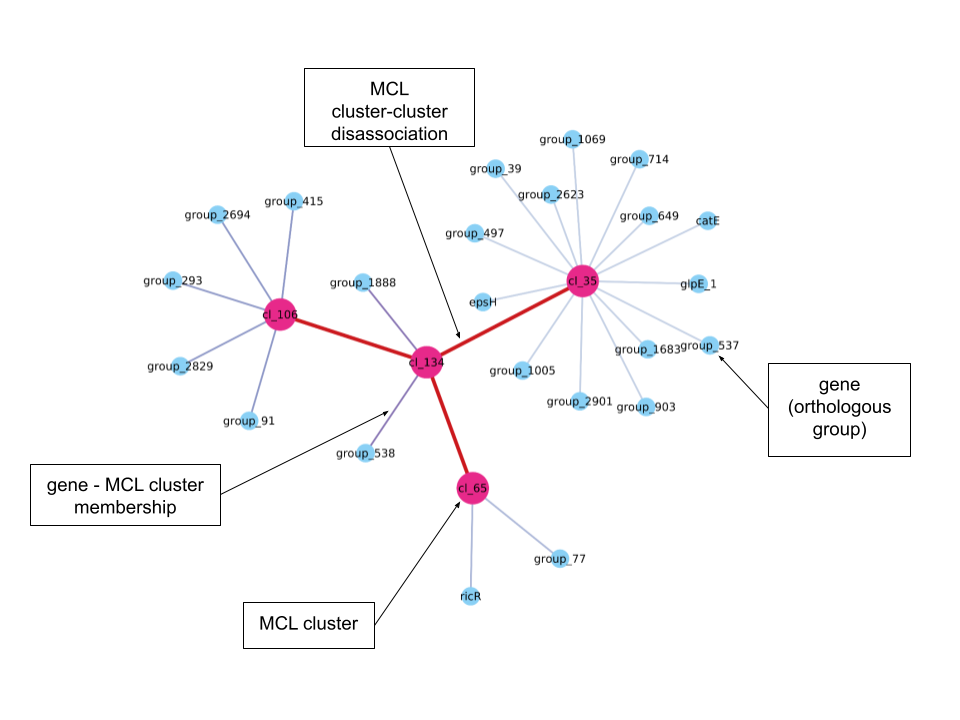


Done


In [6]:
### visualize most significant interactions only or all of them?
onlysignificant = True
### if onlysignificant=True, what is the threshold for the Force value (inclusive)?
force_T = 1.5
### If onlysignificant=False, do we want to keep the node positions stable or not? change variable here
keep_node_positions = False
### If onlysignificant=False, how many edges should be visualized at a time? change variable here
nrows = 50

### import associations first
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_clusterdis_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder_allassoc')

today = date.today()
todaystr = today.strftime("%y%m%d")

if onlysignificant:
    cluster_edges_df.sort_values('Force', ascending=False, inplace=True)
    significant_cluster_edges_df = cluster_edges_df[cluster_edges_df['Force'] >= force_T]
    sign_cl_cl_disassociation_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
    sign_cl_cl_disassociation_pairs = [list(ele) for ele in sign_cl_cl_disassociation_pairs]
    p4c.add_cy_edges(sign_cl_cl_disassociation_pairs, edge_type='disassociation')
    current_network_name = f'Gene-MCL cluster associations and significant (Force>={force_T}) cluster-cluster disassociations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
    time.sleep(1)
    ### fix visuals
    p4c.set_visual_style('GOLDfinder_allassoc_partialDis')
    ### save the figure
    outfig_name=f'{todaystr}_GOLDfinder_top_MCLclusters_disassoc_T{force_T}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### save session
    outcys_session_name = f'{todaystr}_GOLDfinder_top_MCLclusters_disassoc_T{force_T}.cys'
    p4c.save_session(os.path.join(outdir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")
else:
    ### now add disassociation edges
    index = 0
    cluster_edges_df.sort_values('Force', ascending=False, inplace=True)
    ### deal with first network first
    significant_cluster_edges_df = cluster_edges_df.iloc[index*nrows:(index+1)*nrows, :]
    sign_cl_cl_disassociation_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
    sign_cl_cl_disassociation_pairs = [list(ele) for ele in sign_cl_cl_disassociation_pairs]
    p4c.add_cy_edges(sign_cl_cl_disassociation_pairs, edge_type='disassociation')
    current_network_name = f'Gene-MCL cluster associations and top {nrows} cluster-cluster disassociations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### save the figure
    outfig_name= f'{todaystr}_allassoc_manyDis_networks_{index}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
    time.sleep(1)
    
    ### fix visuals
    p4c.set_visual_style('GOLDfinder_allassoc_partialDis')
    
    ### then copy network, remove disassociation edges and repeat
    while nrows * index < len(cluster_edges_df):
        index+=1
        ### clone network (unfortunately also copies collection name based on network name)
        p4c.clone_network()
        ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
        time.sleep(1)
        try:
            significant_cluster_edges_df = cluster_edges_df.iloc[index*nrows:(index+1)*nrows, :]
            current_network_name = f'Gene-MCL cluster associations and next {nrows} ({(index*nrows) + 1} to {(index+1)* nrows}) cluster-cluster disassociations'
        except:
            significant_cluster_edges_df = cluster_edges_df.iloc[index*nrows:, :]
            current_network_name = f'Gene-MCL cluster associations and final {len(significant_cluster_edges_df)} cluster-cluster disassociations'
        if len(significant_cluster_edges_df) == 0:
            break
        #### remove current edges
        p4c.rename_network(current_network_name)
        p4c.select_edges('disassociation', by_col='interaction', preserve_current_selection=False, network=current_network_name)#, network='My Network')
        p4c.delete_selected_edges()
        ### generate new ones
        sign_cl_cl_disassociation_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
        sign_cl_cl_disassociation_pairs = [list(ele) for ele in sign_cl_cl_disassociation_pairs]
        p4c.add_cy_edges(sign_cl_cl_disassociation_pairs, edge_type='disassociation')
        #### maybe here also add Force column again??? like import table?????
        ### at this point decide if the layout should be recalculated or not
        if not keep_node_positions:
            p4c.layout_network('force-directed')
        ### fix visuals
        p4c.set_visual_style('GOLDfinder_allassoc_partialDis')
        ### save the figure
        outfig_name= f'{todaystr}_allassoc_manyDis_networks_{index}.jpeg'
        # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
        p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
        print(f"Saving figure in file {outfig_name}")
    
    print("Applied custom style (GOLDfinder_allassoc_partialDis) to all networks")
    
    ### save session 
    if not keep_node_positions:
        outcys_session_name = f'{todaystr}_allassoc_manyDis_networks_difflayout.cys'
    else:
        outcys_session_name = f'{todaystr}_allassoc_manyDis_networks_samelayout.cys'
    print(f"Saving session in file {outcys_session_name}")
    p4c.save_session(os.path.join(outdir, outcys_session_name))
### show example legend
example1 = os.path.join(examples_dir, '1_visualisation_legend.png')
display(Image(filename=example1))
print('\nDone')

## 1b: Visualizing MCL disassociations - gene-based prioritization



Distribution of gene scores


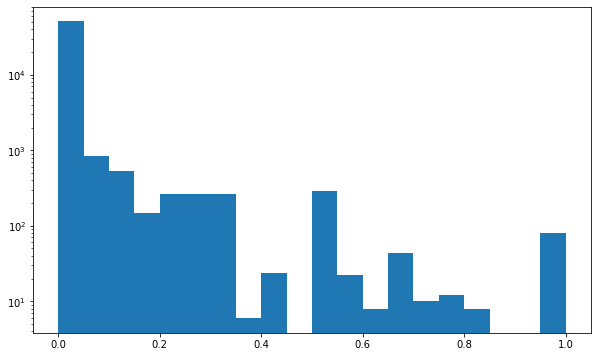

In [18]:
### test distribution of values first - this actually takes a while :(
today = date.today()
todaystr = today.strftime("%y%m%d")
### distribution of gene_scores, for each gene and each pair of MCL clusters - too many possibilities to calculate
all_gene_scores = []
included_pairs = []
distribution_genescores_fig = os.path.join(inputdir, f'custom_gene_scores_distribution.png')
if not os.path.exists(distribution_genescores_fig):
    ### check every MCL cluster vs every other MCL cluster
    for query_cluster in cluster_list:
        query_node_num = len(cluster_to_gene_dict[query_cluster])
        query_gene_list = cluster_to_gene_dict[query_cluster]
        for target_cluster in cluster_list:
            ### skip if same cluster or already seen pair of clusters
            if query_cluster == target_cluster or set([query_cluster, target_cluster]) in included_pairs:
                continue
            target_node_num = len(cluster_to_gene_dict[target_cluster])
            target_gene_list = cluster_to_gene_dict[target_cluster]
            ### now check if there are disassociations between the two MCL clusters
            betweenMCL_dis_edges_df = outside_MCL_gene_disassoc_edges_df[((outside_MCL_gene_disassoc_edges_df['clustersource'] == query_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == target_cluster)) | ((outside_MCL_gene_disassoc_edges_df['clustersource'] == target_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == query_cluster))]
            total_nodes = query_node_num + target_node_num
            ### there may be none, so skip if so (speeds up the process if we don't count zeroes)
            if not len(betweenMCL_dis_edges_df):
                #all_gene_scores = all_gene_scores + [0] * (total_nodes)
                continue
            ### query hits
            for gene in query_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / target_node_num
                all_gene_scores.append(thisgenescore)
            ### target hits
            for gene in target_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / query_node_num
                all_gene_scores.append(thisgenescore)
        #print(len(all_gene_scores))
    ### now visualize the distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    all_gene_scores_np = np.array(all_gene_scores)
    plt.hist(all_gene_scores_np, bins=20)
    plt.yscale('log')
    print("\n\nDistribution of gene scores")
    plt.show()
    fig.savefig(distribution_genescores_fig)
else:
   display(Image(filename=distribution_genescores_fig))
#print(len(all_gene_scores_np))

     source  target  GeneForce
0      cl_1  cl_117   0.214286
1      cl_5   cl_56   0.032258
2      cl_5   cl_98   0.030303
3      cl_5  cl_171   0.032258
4      cl_5  cl_181   0.032258
..      ...     ...        ...
121  cl_123  cl_129   0.200000
122  cl_123  cl_156   0.007299
123  cl_138  cl_147   0.200000
124  cl_152  cl_165   0.024390
125  cl_163  cl_181   0.200000

[126 rows x 3 columns]


Distribution of GeneForce values


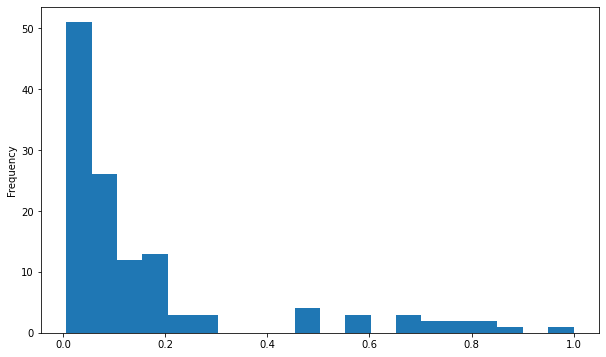

Applying default style...
Applying preferred layout
     source  target  GeneForce                     shared name
0      cl_1  cl_117   0.214286    cl_1 (disassociation) cl_117
1      cl_5   cl_56   0.032258     cl_5 (disassociation) cl_56
2      cl_5   cl_98   0.030303     cl_5 (disassociation) cl_98
3      cl_5  cl_171   0.032258    cl_5 (disassociation) cl_171
4      cl_5  cl_181   0.032258    cl_5 (disassociation) cl_181
..      ...     ...        ...                             ...
121  cl_123  cl_129   0.200000  cl_123 (disassociation) cl_129
122  cl_123  cl_156   0.007299  cl_123 (disassociation) cl_156
123  cl_138  cl_147   0.200000  cl_138 (disassociation) cl_147
124  cl_152  cl_165   0.024390  cl_152 (disassociation) cl_165
125  cl_163  cl_181   0.200000  cl_163 (disassociation) cl_181

[126 rows x 4 columns]


In export_image(): This file already exists and will not be overwritten: /media/hdd_2tb/side_projects/amycolatopsis_pangenome/emil_GOLDfinder_project/clean_publication_figures/240215_GOLDfinder_MCLclusters_disassoc_disT0.5_geneT0.jpeg


CyError: In export_image(): This file already exists and will not be overwritten: /media/hdd_2tb/side_projects/amycolatopsis_pangenome/emil_GOLDfinder_project/clean_publication_figures/240215_GOLDfinder_MCLclusters_disassoc_disT0.5_geneT0.jpeg

In [21]:
### instead of force, or existing MCL-MCL disassociations, create metric that is based on genes, not pairs of genes (avoids bias between different sizes of MCL clusters)
today = date.today()
todaystr = today.strftime("%y%m%d")
### specify inclusive threshold (>=) accepting a hit in the MCL-MCL disassociations (percentage of genes in MCL cluster that a gene of another MCL cluster is dissassociated with)
disT = 0.5
### specify not-inclusive hit score threshold (>) for showing the MCL-MCL disassociation edges
hitT = 0
specialMCLclusters_dis_edges_dict = {}
index_counter = 0
### save into file to avoid recalculating
specialMCLclusters_dis_edges_table = os.path.join(inputdir, f'custom_specialMCLclusters_dis_edges_table_{disT}_{hitT}.csv')
if not os.path.exists(specialMCLclusters_dis_edges_table):
    included_pairs = []
    ### check every MCL cluster vs every other MCL cluster
    for query_cluster in cluster_list:
        query_node_num = len(cluster_to_gene_dict[query_cluster])
        query_gene_list = cluster_to_gene_dict[query_cluster]
        for target_cluster in cluster_list:
            ### skip if same cluster or already seen pair of clusters
            if query_cluster == target_cluster or set([query_cluster, target_cluster]) in included_pairs:
                continue
            target_node_num = len(cluster_to_gene_dict[target_cluster])
            target_gene_list = cluster_to_gene_dict[target_cluster]
            ### now check if there are disassociations between the two MCL clusters
            betweenMCL_dis_edges_df = outside_MCL_gene_disassoc_edges_df[((outside_MCL_gene_disassoc_edges_df['clustersource'] == query_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == target_cluster)) | ((outside_MCL_gene_disassoc_edges_df['clustersource'] == target_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == query_cluster))]
            ### there may be none, so skip if so
            if not len(betweenMCL_dis_edges_df):
                continue
            #print(betweenMCL_dis_edges_df)
            #print(len(betweenMCL_dis_edges_df))
            ### now calculate the metric
            total_nodes = query_node_num + target_node_num
            ### query hits
            query_hits = 0
            for gene in query_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / target_node_num
                if thisgenescore >= disT:
                    query_hits += 1
            ### target hits
            target_hits = 0
            for gene in target_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / query_node_num
                if thisgenescore >= disT:
                    target_hits += 1
            ### total score and weight - how many hits out of all possible hits (or nodes)
            total_score = (query_hits + target_hits) / total_nodes
            ### include it in the edges dict if the score is more than 0
            if total_score > hitT:
                specialMCLclusters_dis_edges_dict[index_counter] = [query_cluster, target_cluster, total_score]
                index_counter += 1
                included_pairs.append(set([query_cluster, target_cluster]))
            #break
        #if len(betweenMCL_dis_edges_df):
            #break
    ### now turn the dict into a dataframe
    specialMCLclusters_dis_edges_df = pd.DataFrame.from_dict(specialMCLclusters_dis_edges_dict, orient='index', columns=['source', 'target', 'GeneForce'])
    specialMCLclusters_dis_edges_df.to_csv(specialMCLclusters_dis_edges_table, index=False)
    print(f"Created file: {specialMCLclusters_dis_edges_table}")
else:
    specialMCLclusters_dis_edges_df = pd.read_csv(specialMCLclusters_dis_edges_table)
print(specialMCLclusters_dis_edges_df)

### visualize distribution of GeneForce values
these_parameters_distribution_geneforces_fig = os.path.join(inputdir, f'custom_GeneForce_distribution_disT{disT}_geneT{hitT}.png')
if not os.path.exists(these_parameters_distribution_geneforces_fig):
    fig, ax = plt.subplots(figsize=(10, 6))
    specialMCLclusters_dis_edges_df['GeneForce'].plot.hist(bins=20)
    print("\n\nDistribution of GeneForce values")
    fig.savefig(these_parameters_distribution_geneforces_fig)
    plt.show()
else:
   display(Image(filename=these_parameters_distribution_geneforces_fig))

### now visualize
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_clusterdis_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder_allassoc')

genebased_cl_cl_disassociation_pairs = list(zip(specialMCLclusters_dis_edges_df['source'],specialMCLclusters_dis_edges_df['target']))
genebased_cl_cl_disassociation_pairs = [list(ele) for ele in genebased_cl_cl_disassociation_pairs]
p4c.add_cy_edges(genebased_cl_cl_disassociation_pairs, edge_type='disassociation')
current_network_name = f'Gene-MCL cluster associations and significant (disT>={disT}, GeneForce>{hitT}) cluster-cluster disassociations'
p4c.rename_network(current_network_name)
p4c.layout_network('force-directed')
### add also GeneForce as info
specialMCLclusters_dis_edges_df['shared name'] = specialMCLclusters_dis_edges_df[['source','target']].agg(' (disassociation) '.join, axis=1) 
print(specialMCLclusters_dis_edges_df)
p4c.load_table_data(specialMCLclusters_dis_edges_df, data_key_column='shared name', table_key_column='shared name', table='edge')
### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
time.sleep(1)
### fix visuals
p4c.set_visual_style('GOLDfinder_allassoc_genebasedDis')
### save the figure
outfig_name=f'{todaystr}_GOLDfinder_MCLclusters_disassoc_disT{disT}_geneT{hitT}.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
print(f"Saving figure in file {outfig_name}")
### save session
outcys_session_name = f'{todaystr}_GOLDfinder_MCLclusters_disassoc_disT{disT}_geneT{hitT}.cys'
p4c.save_session(os.path.join(outdir, outcys_session_name))
print(f"Saving session in file {outcys_session_name}")


## 2: Visualizing MCL association clusters, their members and the cluster-cluster ASSOCIATIONS (multiple networks)
The following code block will first visualize the genes and their association edges to the MCL clusters. Then, it will iteratively visualize the 200 (nrows) most significant associations between MCL clusters in one network at a time. Depending on the keep_node_positions variable, the layout algorithm will be reapplied with each iteration (False) or the nodes will keep their position as it was in the first visualization (True)
#### Warning: all currently open networks will be deleted before new ones are generated!

Applying default style...
Applying preferred layout


/home/athina/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


        Node1   Node2     Force              pair_type  Node1_ass_degree  \
20094   cl_94  cl_141  1.333333  cluster-cluster-assoc                 1   
20102   cl_95  cl_199  1.333333  cluster-cluster-assoc                 5   
19493   cl_37   cl_54  1.277778  cluster-cluster-assoc                 1   
19744   cl_56  cl_124  1.250000  cluster-cluster-assoc                 8   
19907   cl_72  cl_107  1.250000  cluster-cluster-assoc                13   
...       ...     ...       ...                    ...               ...   
20133  cl_103  cl_164  1.100000  cluster-cluster-assoc                 1   
19499   cl_38   cl_48  1.100000  cluster-cluster-assoc                10   
20192  cl_117  cl_146  1.100000  cluster-cluster-assoc                 3   
19738   cl_56   cl_90  1.100000  cluster-cluster-assoc                 8   
19748   cl_57   cl_89  1.100000  cluster-cluster-assoc                 3   

       Node2_ass_degree  max_ass_degree  
20094                 4               4  
201

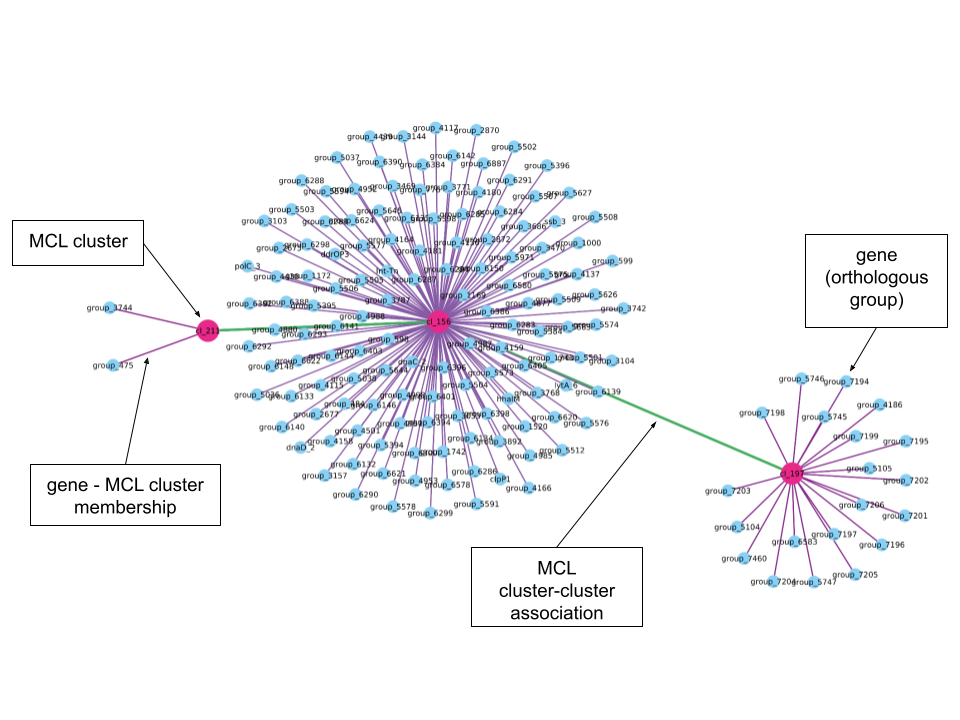


Done


In [147]:
### visualize most significant interactions only or all of them?
onlysignificant = True
### if onlysignificant=True, what is the threshold for the Force value (inclusive)?
force_T = 1.1
### If onlysignificant=False, do we want to keep the node positions stable or not? change variable here
keep_node_positions = False
### If onlysignificant=False, how many edges should be visualized at a time? change variable here
nrows = 50

today = date.today()
todaystr = today.strftime("%y%m%d")

### import associations first
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)

if onlysignificant:
    cluster_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)
    #print(cluster_assoc_edges_df)
    significant_cluster_assoc_edges_df = cluster_assoc_edges_df[cluster_assoc_edges_df['Force'] >= force_T]
    print(significant_cluster_assoc_edges_df)
    sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['Node1'],significant_cluster_assoc_edges_df['Node2']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='association')
    current_network_name = f'Gene-MCL cluster associations and significant (Force>={force_T}) cluster-cluster associations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
    time.sleep(1)
    ### fix visuals
    p4c.set_visual_style('GOLDfinder_allassoc')
    ### save the figure
    outfig_name= f'{todaystr}_GOLDfinder_top_MCLclusters_assoc_T{force_T}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### save session
    outcys_session_name = f'{todaystr}_GOLDfinder_top_MCLclusters_assoc_T{force_T}.cys'
    p4c.save_session(os.path.join(outdir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")
else:
    ### now add association edges
    index = 0
    cluster_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)
    ### deal with first network first
    significant_cluster_assoc_edges_df = cluster_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
    sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['Node1'],significant_cluster_assoc_edges_df['Node2']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='association')
    current_network_name = f'Gene-MCL cluster associations and top {nrows} cluster-cluster associations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### save the figure
    outfig_name= f'{todaystr}_allassoc_manyclAs_networks_{index}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
    print(f"Saving figure in file {outfig_name}")
    time.sleep(1)
    
    ### fix visuals
    p4c.set_visual_style('GOLDfinder_allassoc')
    
    ### then copy network, remove association edges and repeat
    while nrows * index < len(cluster_assoc_edges_df):
        index+=1
        ### clone network (unfortunately also copies collection name based on network name)
        p4c.clone_network()
        time.sleep(1)
        try:
            significant_cluster_edges_df = cluster_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
            current_network_name = f'Gene-MCL cluster associations and next {nrows} ({(index*nrows) + 1} to {(index+1)* nrows}) cluster-cluster associations'
        except:
            significant_cluster_edges_df = cluster_assoc_edges_df.iloc[index*nrows:, :]
            current_network_name = f'Gene-MCL cluster associations and final {len(significant_cluster_edges_df)} cluster-cluster associations'
        if len(significant_cluster_edges_df) == 0:
            break
        #### remove current edges
        p4c.rename_network(current_network_name)
        p4c.select_edges('association', by_col='interaction', preserve_current_selection=False, network=current_network_name)#, network='My Network')
        p4c.delete_selected_edges()
        ### then generate new ones
        sign_cl_cl_association_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
        sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
        p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='association')
        ### at this point decide if the layout should be recalculated or not
        if not keep_node_positions:
            p4c.layout_network('force-directed')
        ### fix visuals
        p4c.set_visual_style('GOLDfinder_allassoc')
        ### save the figure
        outfig_name= f'{todaystr}_allassoc_manyclAs_networks_{index}.jpeg'
        # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
        p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
        print(f"Saving figure in file {outfig_name}")
    
    print("Applied custom style (GOLDfinder_allassoc) to all networks")
    
    ### save session - change path as needed
    today = date.today()
    todaystr = today.strftime("%y%m%d")
    if not keep_node_positions:
        outcys_session_name = f'{todaystr}_allassoc_manyclAs_networks_difflayout.cys'
    else:
        outcys_session_name = f'{todaystr}_allassoc_manyclAs_networks_samelayout.cys'
    p4c.save_session(os.path.join(outdir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")
### show example legend
example2 = os.path.join(examples_dir, '2_visualisation_legend.png')
display(Image(filename=example2))
print('\nDone')

## 3: Visualizing MCL association clusters, their members and the gene-gene ASSOCIATIONS happening across MCL clusters (multiple networks)
The following code block will first visualize the genes and their association edges to the MCL clusters. Then, it will iteratively visualize the 1000 (nrows) most significant associations between genes that do NOT belong in the same MCL cluster, in one network at a time. Depending on the keep_node_positions variable, the layout algorithm will be reapplied with each iteration (False) or the nodes will keep their position as it was in the first visualization (True)
#### Warning: all currently open networks will be deleted before new ones are generated!

Applying default style...
Applying preferred layout


/home/athina/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Applied custom style (GOLDfinder_allassoc) to all networks
Saving session in file 240123_allassoc_extraMCLgenegene_networks_difflayout.cys


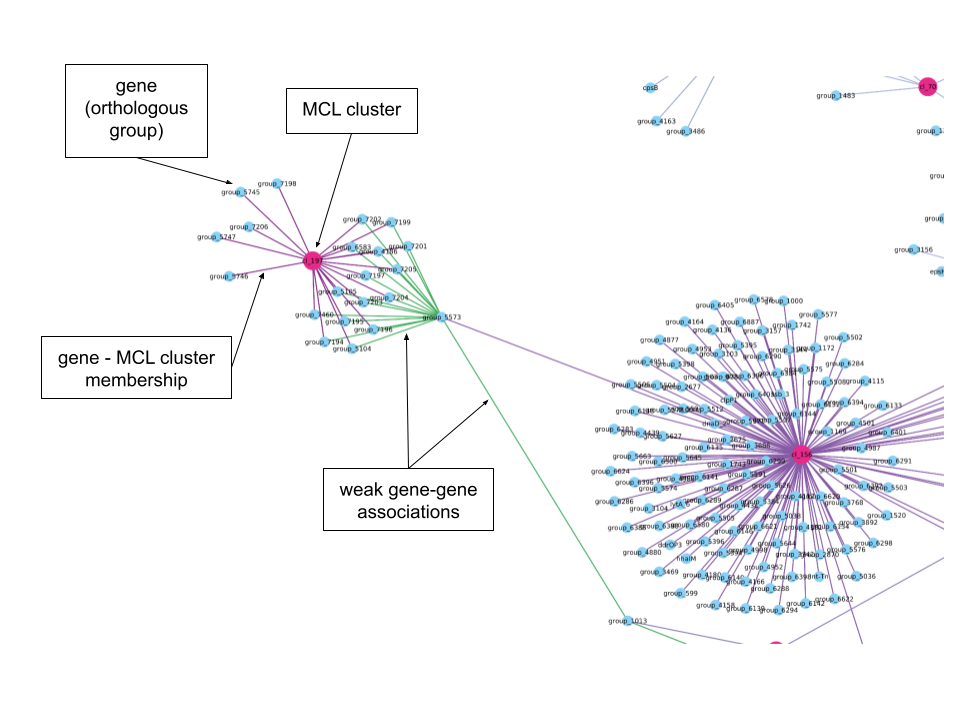


Done


In [130]:
### do we want to keep the node positions stable or not? change variable here
keep_node_positions = False
### how many edges should be visualized at a time? change variable here
nrows = 1000

today = date.today()
todaystr = today.strftime("%y%m%d")

### import associations first
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)

### now add outside of MCL cluster gene-gene association edges
index = 0

outside_MCL_gene_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)

### deal with first network first
significant_cluster_assoc_edges_df = outside_MCL_gene_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['source'],significant_cluster_assoc_edges_df['target']))
sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
current_network_name = f'Gene-MCL cluster associations and top {nrows} gene-gene associations across MCL clusters'
p4c.rename_network(current_network_name)
p4c.layout_network('force-directed')
### save the figure
outfig_name= f'{todaystr}_allassoc_extraMCLgenegene_networks_{index}.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
print(f"Saving figure in file {outfig_name}")
time.sleep(1)

### fix visuals
p4c.set_visual_style('GOLDfinder_allassoc')

### then copy network, remove association edges and repeat
while nrows * index < len(outside_MCL_gene_assoc_edges_df):
    #print(index)
    index+=1
    ### clone network (unfortunately also copies collection name based on network name)
    p4c.clone_network()
    time.sleep(1)
    try:
        significant_cluster_edges_df = outside_MCL_gene_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
        current_network_name = f'Gene-MCL cluster associations and next {nrows} ({(index*nrows) + 1} to {(index+1)* nrows}) gene-gene associations across MCL clusters'
    except:
        significant_cluster_edges_df = outside_MCL_gene_assoc_edges_df.iloc[index*nrows:, :]
        current_network_name = f'Gene-MCL cluster associations and final {len(significant_cluster_edges_df)} gene-gene associations across MCL clusters'
    if len(significant_cluster_edges_df) == 0:
        break
    #### remove current edges
    p4c.rename_network(current_network_name)
    p4c.select_edges('weak_association', by_col='interaction', preserve_current_selection=False, network=current_network_name)#, network='My Network')
    p4c.delete_selected_edges()
    ### then generate new ones
    sign_cl_cl_association_pairs = list(zip(significant_cluster_edges_df['source'],significant_cluster_edges_df['target']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
    ### at this point decide if the layout should be recalculated or not
    if not keep_node_positions:
        p4c.layout_network('force-directed')
    ### fix visuals
    p4c.set_visual_style('GOLDfinder_allassoc')
    ### save the figure
    outfig_name= f'{todaystr}_allassoc_extraMCLgenegene_networks_{index}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
    print(f"Saving figure in file {outfig_name}")


print("Applied custom style (GOLDfinder_allassoc) to all networks")

### save session - change path as needed
if not keep_node_positions:
    outcys_session_name = f'{todaystr}_allassoc_extraMCLgenegene_networks_difflayout.cys'
else:
    outcys_session_name = f'{todaystr}_allassoc_extraMCLgenegene_networks_samelayout.cys'
p4c.save_session(os.path.join(outdir, outcys_session_name))
print(f"Saving session in file {outcys_session_name}")
### show example legend
example3 = os.path.join(examples_dir, '3_visualisation_legend.png')
display(Image(filename=example3))
print('\nDone')

## 4: Visualizing all associations between genes 

The following code block will visualize the genes and their association edges to other genes. The nodes will be coloured according to MCL cluster membership

#### Warning: all currently open networks will be deleted before new ones are generated!

In [139]:
### deleting existing networks to start over
p4c.delete_all_networks()

today = date.today()
todaystr = today.strftime("%y%m%d")

### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
#print(gene_assoc_edges_df)
p4c.create_network_from_data_frames(gene_nodes_df,gene_assoc_edges_df , title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder_allassoc')
### save the figure
outfig_name= f'{todaystr}_GOLDfinder_allassoc.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
print(f"Saving figure in file {outfig_name}")
### save the session
outcys_session_name = f'{todaystr}_GOLDfinder_allassoc.cys'
p4c.save_session(os.path.join(outdir, outcys_session_name))
print(f"Saving session in file {outcys_session_name}")


           source      target     Force        pair_type clustersource  \
0            pbuO        adhA -0.496975  gene-gene-assoc          cl_9   
1           nagAa      glnQ_2 -0.496975  gene-gene-assoc         cl_22   
2            birA      araQ_3 -0.490086  gene-gene-assoc         cl_25   
3            citS  group_8316 -0.500000  gene-gene-assoc         cl_27   
4      group_4452        acpB -0.500000  gene-gene-assoc         cl_13   
...           ...         ...       ...              ...           ...   
18438  group_2329  group_2328 -0.482171  gene-gene-assoc        cl_129   
18439  group_5293  group_2556 -0.467728  gene-gene-assoc         cl_73   
18440  group_5293  group_1886 -0.467728  gene-gene-assoc         cl_73   
18441  group_5293  group_1854 -0.467728  gene-gene-assoc         cl_73   
18442  group_5293  group_1645 -0.490086  gene-gene-assoc         cl_73   

      clustertarget  withinMCL  
0              cl_9       True  
1             cl_22       True  
2           

/home/athina/.local/lib/python3.7/site-packages/py4cytoscape/networks.py:1106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if not interaction_type_list in edges.columns: edges[interaction_type_list] = 'interacts with'


Applying default style...
Applying preferred layout
Saving session in file 240123_GOLDfinder_allassoc.cys


## 5: Visualizing all associations between genes belonging to the same MCL cluster

The following code block will visualize the genes and their association edges to other genes only if both genes belong to the same MCL cluster. The nodes will be coloured according to MCL cluster membership. If the addamong variable is set to True, then also the among MCL cluster gene-gene associations will be drawn, which will be more transparent, without affecting the layout.

#### Warning: all currently open networks will be deleted before new ones are generated!

In [148]:
### do you want to add also the amongMCLcluster associations? ---- this is what is used to create the GOLDfinder comparison figure. First visualize all within MCL gene-gene associations. Then add the among MCL gnee-gene asociations (transparency 20). Then add the COINfinder network as in a code block further below, and copycat the layout of this one.
addamong = True
### deleting existing networks to start over
p4c.delete_all_networks()

today = date.today()
todaystr = today.strftime("%y%m%d")

### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
#print(gene_assoc_edges_df)
p4c.create_network_from_data_frames(gene_nodes_df,gene_assoc_edges_df[gene_assoc_edges_df['withinMCL'] == True] , title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder_allassoc')
### save the figure
outfig_name= f'{todaystr}_GOLDfinder_allassocwithincMCLcluster.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
print(f"Saving figure in file {outfig_name}")
### save this as basic figure
outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithincMCLcluster.cys'
p4c.save_session(os.path.join(outdir, outcys_session_name))
print(f"Saving session in file {outcys_session_name}")

if addamong:
    outside_MCL_gene_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)
    significant_cluster_assoc_edges_df = outside_MCL_gene_assoc_edges_df#.iloc[index*nrows:(index+1)*nrows, :]
    sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['source'],significant_cluster_assoc_edges_df['target']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
    ### save the figure
    outfig_name= f'{todaystr}_GOLDfinder_allassocwithincMCLcluster_plusAmong.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(outdir, outfig_name), type='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### save this as basic figure
    outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithincMCLcluster_plusAmong.cys'
    p4c.save_session(os.path.join(outdir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")


Applying default style...
Applying preferred layout
This file has been overwritten.
Saving session in file 240124_GOLDfinder_allassocwithincMCLcluster.cys


/home/athina/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Saving session in file 240124_GOLDfinder_allassocwithincMCLcluster_plusAmong.cys


## Special case: GOLDfinder-COINfinder comparison
### Data import
The following code block imports all information necessary from the COINfinder results files and prepares the data in a format ready to be visualized. No network is generated in cytoscape yet.

In [6]:
### don't run by default
if True:
    coinfinder_dir = '/media/hdd_2tb/side_projects/amycolatopsis_pangenome/emil_GOLDfinder_project/precomputed_results/coinfinder_for_comparison'
    
    coin_association_clusters_file = os.path.join(coinfinder_dir, 'coinfinder_clusters_no_duplicates.txt')
    coin_associated_pairs_file = os.path.join(coinfinder_dir, 'coinfinder_result.tsv')
    
    ### get info from coinfinder files
    ### get info from coinfinder_result file
    coin_assoc_pairs_df = pd.read_csv(coin_associated_pairs_file, sep='\t')
    coin_assoc_pairs_df.rename(columns={'Source':'source', 'Target':'target'}, inplace=True)
    #print(coin_assoc_pairs_df)
    coin_gene1_df = coin_assoc_pairs_df[['source']]
    coin_gene2_df = coin_assoc_pairs_df[['target']]
    coldict = {'source':'Gene', 
               'target':'Gene'}
    coin_gene1_df.rename(columns=coldict, inplace=True)
    coin_gene2_df.rename(columns=coldict, inplace=True)
    coin_gene_nodes_df = pd.concat([coin_gene1_df, coin_gene2_df])
    coin_gene_nodes_df.drop_duplicates(inplace=True)
    coin_gene_nodes_df['id'] = coin_gene_nodes_df['Gene']
    coin_gene_nodes_df['isgene'] = True
    coin_genes_list = list(set(coin_gene_nodes_df['Gene'].tolist()))
    
    
    ### get info from coin_clusters file
    coin_gene_to_cluster_dict = {}
    coin_cluster_list = []
    with open(coin_association_clusters_file, 'r') as infile:
        new_cluster = False
        for line in infile.readlines():
            line = line.rstrip()
            line = line.rstrip(',')
            if line.startswith('>'):
                cluster_num = line[1:].split(",")[0]
                coin_cluster_list.append('cl_%s' %(cluster_num))
                continue
            if line in coin_gene_to_cluster_dict.keys():
                if coin_gene_to_cluster_dict[line] != 'cl_%s' %(cluster_num):
                    print("ERROR: gene with multiple cluster assingments detected: %s" %(line))
                    exit()
            coin_gene_to_cluster_dict[line] = 'cl_%s' %(cluster_num)
    
    ### add cluster info to gene_nodes_df
    coin_gene_nodes_df['Cluster'] = coin_gene_nodes_df['Gene'].map(coin_gene_to_cluster_dict)
    print("Checking for empty cells in node table...")
    print("Found:", coin_gene_nodes_df.isnull().sum().sum())
    coin_gene_nodes_df.fillna('', inplace=True)
    
    ### generate coin_gene_to_cluster_edges_df
    coin_gene_to_cluster_edges_df = coin_gene_nodes_df.loc[coin_gene_nodes_df['Cluster'] != ''][['Gene', 'Cluster']]
    coin_rename_cols_dict = {'Gene': 'source', 'Cluster': 'target'}
    coin_gene_to_cluster_edges_df.rename(columns=coin_rename_cols_dict, inplace=True)
    coin_cluster_list = list(set(coin_gene_to_cluster_edges_df['target'].tolist()))
    coin_cluster_nodes_df = pd.DataFrame(coin_cluster_list)
    coin_cluster_nodes_df.rename(columns={0:"Gene"}, inplace=True)
    coin_cluster_nodes_df['isgene'] = False
    coin_cluster_nodes_df['Cluster'] = coin_cluster_nodes_df['Gene']

    coin_gene_to_cluster_edges_df['Cluster_num'] = coin_gene_to_cluster_edges_df['target'].map(lambda x: int(x.replace('cl_','')))
    coin_nodes_list = list(set(coin_genes_list + coin_cluster_list))
    coin_gene_nodes_df['Cluster_num'] = coin_gene_nodes_df['Cluster'].map(lambda x: int(x.replace('cl_','')) if x != '' else  0)
    
    coin_all_assoc_nodes_df = pd.concat([coin_gene_nodes_df, coin_cluster_nodes_df])
    coin_all_assoc_nodes_df = coin_all_assoc_nodes_df.set_index('Gene').reindex(index=coin_nodes_list).fillna('').reset_index()
    coin_all_assoc_nodes_df['id'] = coin_all_assoc_nodes_df['Gene']
    #print(coin_all_assoc_nodes_df)
    
    ### get info for gene-gene associations happening across MCL clusters
    def withinMCLconditions(row):
        if row['clustersource'] == row['clustertarget']:
            return True
        else:
            return False
    coin_assoc_pairs_df['clustersource'] = coin_assoc_pairs_df['source'].map(coin_gene_to_cluster_dict)
    coin_assoc_pairs_df['clustertarget'] = coin_assoc_pairs_df['target'].map(coin_gene_to_cluster_dict)
    coin_assoc_pairs_df['withinMCL'] = coin_assoc_pairs_df.apply(withinMCLconditions, axis=1)
    coin_outside_MCL_gene_assoc_edges_df =coin_assoc_pairs_df[coin_assoc_pairs_df['withinMCL'] == False]
    
    coin_sign_cl_cl_association_pairs_all = list(zip(coin_outside_MCL_gene_assoc_edges_df['source'], coin_outside_MCL_gene_assoc_edges_df['target']))
    coin_sign_cl_cl_association_pairs_all = list(chain.from_iterable([list(ele) for ele in coin_sign_cl_cl_association_pairs_all]))

    #print(coin_gene_to_cluster_edges_df)
    #print(coin_cluster_nodes_df)
    #print(coin_gene_nodes_df)
    #print(coin_assoc_pairs_df)
    
    combo_coin_all_assoc_nodes_df = coin_all_assoc_nodes_df.copy()
    combo_coin_all_assoc_nodes_df['Gene'] = coin_all_assoc_nodes_df['Gene'].map(lambda x: x.replace('cl_','c_cl_'))
    combo_coin_all_assoc_nodes_df['id'] = combo_coin_all_assoc_nodes_df['Gene']
    combo_coin_all_assoc_nodes_df['algorithm'] = np.where(combo_coin_all_assoc_nodes_df['isgene'] == False, 'coin', '')
    combo_coin_gene_to_cluster_edges_df = coin_gene_to_cluster_edges_df.copy()
    combo_coin_gene_to_cluster_edges_df['target'] = coin_gene_to_cluster_edges_df['target'].map(lambda x: x.replace('cl_','c_cl_'))
    combo_gold_all_assoc_clusterdis_nodes_df = all_assoc_clusterdis_nodes_df.copy()
    combo_gold_all_assoc_clusterdis_nodes_df['Gene'] = all_assoc_clusterdis_nodes_df['Gene'].map(lambda x: x.replace('cl_','g_cl_'))
    combo_gold_all_assoc_clusterdis_nodes_df['id'] = combo_gold_all_assoc_clusterdis_nodes_df['Gene']
    combo_gold_all_assoc_clusterdis_nodes_df['algorithm'] = np.where(combo_gold_all_assoc_clusterdis_nodes_df['isgene'] == False, 'gold', '')
    combo_gold_gene_to_cluster_edges_df = gene_to_cluster_edges_df.copy()
    combo_gold_gene_to_cluster_edges_df['target'] = gene_to_cluster_edges_df['target'].map(lambda x: x.replace('cl_','g_cl_'))
    
    
    
    print("\nDone")

/home/athina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Checking for empty cells in node table...
Found: 74
           source  target  Cluster_num
0        group_45    cl_1            1
62      group_450   cl_37           37
202    group_4505   cl_46           46
289    group_4509    cl_2            2
352     group_451   cl_61           61
...           ...     ...          ...
10135   group_579   cl_81           81
10989      xerC_1  cl_147          147
11255        mutS   cl_21           21
14225        tadA   cl_30           30
22884      ytpP_2  cl_170          170

[906 rows x 3 columns]
       Gene  isgene Cluster
0     cl_69   False   cl_69
1     cl_46   False   cl_46
2     cl_92   False   cl_92
3    cl_158   False  cl_158
4     cl_36   False   cl_36
..      ...     ...     ...
175   cl_49   False   cl_49
176   cl_13   False   cl_13
177  cl_168   False  cl_168
178  cl_123   False  cl_123
179   cl_40   False   cl_40

[180 rows x 3 columns]
             Gene          id  isgene Cluster  Cluster_num
0        group_45    group_45    True

### Figure generation: GOLDfinder - COINfinder comparison

In [12]:
### Creating Fig1 of GOLDfinder manuscript: GOLDfinder-COINfinder comparison
addamong = True
addandcopyCOINfinder = True

today = date.today()
todaystr = today.strftime("%y%m%d")

### start from GOLDfinder
### deleting existing networks to start over
p4c.delete_all_networks()

### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(gene_nodes_df, within_MCL_gene_assoc_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder-COINfinder_copycatFig1')
### save the figure
outfig_name= f'{todaystr}_GOLDfinder_allassocwithinMCLcluster.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
p4c.export_image(os.path.join(coinfinder_dir, outfig_name), type='JPEG')
print(f"Saving figure in file {outfig_name}")
### save the session
outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithinMCLcluster.cys'
p4c.save_session(os.path.join(coinfinder_dir, outcys_session_name))
print(f"Saving session in file {outcys_session_name}")

### now add the among MCL clusters associations
if addamong:
    significant_cluster_assoc_edges_df = coin_outside_MCL_gene_assoc_edges_df
    sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['source'],significant_cluster_assoc_edges_df['target']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
    ### save the figure
    outfig_name= f'{todaystr}_GOLDfinder_allassocwithinMCLcluster_plusAmong.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(coinfinder_dir, outfig_name), type='JPEG')
    ### save the session
    outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithinMCLcluster_plusAmong.cys'
    p4c.save_session(os.path.join(coinfinder_dir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")

if addandcopyCOINfinder:
    ### now make a new network with COINfinder associations
    collection_title = "COINfinder results"
    p4c.create_network_from_data_frames(combo_coin_all_assoc_nodes_df, combo_coin_gene_to_cluster_edges_df, title="COINfinder gene association network", collection=collection_title)
    p4c.layout_copycat(source='GOLDfinder gene association network',target='COINfinder gene association network')
    p4c.set_visual_style('GOLDfinder-COINfinder_copycatFig1')
     ### save the figure
    outfig_name= f'{todaystr}_copycat_COINfinder_allassocwithinMCLcluster_plusAmong.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    p4c.export_image(os.path.join(coinfinder_dir, outfig_name), type='JPEG')
    ### save the session
    outcys_session_name = f'{todaystr}_copycat_COINfinder_allassocwithinMCLcluster_plusAmong.cys'
    p4c.save_session(os.path.join(coinfinder_dir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")
print('\nDone')

Applying default style...
Applying preferred layout

Done


In [8]:
### make combined network of both GOLD and COIN -----   this is what we use to add the COINfinder network after the GOLDfinder network (all within MCL-gene-gene associations plus added among associations)
#### after importing, copycat layout of GOLDfinder and use the same style


'''
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(combo_gold_all_assoc_clusterdis_nodes_df, combo_gold_gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder_allassoc')
'''

Applying default style...
Applying preferred layout


'\n### make associations network inlcuding MCL clusters\ncollection_title = "GOLDfinder results"\np4c.create_network_from_data_frames(combo_gold_all_assoc_clusterdis_nodes_df, combo_gold_gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)\np4c.layout_network(\'force-directed\')\np4c.set_visual_style(\'GOLDfinder_allassoc\')\n'